## Lab 06: Deep Neural Nets applied to Classification Problem

### Case of study 04: Breast Cancer Classification

### 1. Metadata  

* **data**: This is a 2D array (matrix) containing the features of the dataset. Each row corresponds to a sample (tumor), and each column corresponds to a feature (measurement).  
* **target**: This is a 1D array containing the labels for each sample. The labels indicate whether the tumor is malignant (1) or benign (0).   
* **feature_names**: This is a list of strings representing the names of the features in the dataset.   
* **target_names**: This is a list of strings representing the names of the target classes. In this case, it indicates the two classes: malignant and benign.  
* **DESCR**: This is a string containing a detailed description of the dataset, including information about how it was collected, its purpose, and any relevant notes.  
* **filename**: This is a string that indicates the path to the dataset file  
* **data_module**: This field indicates the source of the dataset.

In [2]:
# import packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sbn
import matplotlib.pyplot as plt
import time

### 2. Load dataset

In [3]:
# load dataset
data = load_breast_cancer()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [4]:
# get column names
metadata = data.feature_names
print(metadata)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### 3. Data Preprocessing

In [5]:
# split independent and dependent variables
x = data.data
y = data.target

In [6]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
# check dimensionality of each subset of data
print("Dimensions in x-train: ", x_train.shape)
print("Dimensions in y-train: ", y_train.shape)
print("Dimensions in x-test: ", x_test.shape)
print("Dimensions in y-test: ", y_test.shape)

Dimensions in x-train:  (455, 30)
Dimensions in y-train:  (455,)
Dimensions in x-test:  (114, 30)
Dimensions in y-test:  (114,)


In [8]:
# transformer will learn only from training data
transformer = StandardScaler()
transformer.fit(x_train)

StandardScaler()

In [9]:
# transformer will apply in the train and test data
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)

In [10]:
# convert data to Pytorch tensor data structure
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [12]:
print("dim x-train tensor: ", x_train_tensor.shape)
print("y-train tensor: ", y_train_tensor.shape)

dim x-train tensor:  torch.Size([455, 30])
y-train tensor:  torch.Size([455, 1])


In [13]:
# Create DataLoaders with batches of data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### 4. Build Model Architecture

In [76]:
# Define the neural network architecture
class ClassifierNeuralNet(nn.Module):
    def __init__(self, input_neurons, num_hidden_layers, hidden_neurons_x_layer, activation, output_neurons):
        super(ClassifierNeuralNet, self).__init__()
        # input layer definition
        layers = [nn.Linear(input_neurons, hidden_neurons_x_layer[0])]
        # hidden layers definition
        for i in range(1, num_hidden_layers):
            layers.append(nn.Linear(hidden_neurons_x_layer[i-1], hidden_neurons_x_layer[i]))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
        # output layer definition
        layers.append(nn.Linear(hidden_neurons_x_layer[-1], output_neurons))
        layers.append(nn.Sigmoid())
        # model architecture definition
        self.model = nn.Sequential(*layers)

    # forward step
    def forward(self, x):
        return self.model(x)

In [14]:
# define list of experiments
experiments = [
    {'num_layers': 2, 'neurons_per_layer': [16, 8], 'activation': 'relu'},
    {'num_layers': 3, 'neurons_per_layer': [32, 16, 8], 'activation': 'relu'},
    {'num_layers': 2, 'neurons_per_layer': [16, 8], 'activation': 'tanh'},
    {'num_layers': 3, 'neurons_per_layer': [32, 16, 8], 'activation': 'tanh'},
    {'num_layers': 2, 'neurons_per_layer': [16, 8], 'activation': 'sigmoid'},
    {'num_layers': 3, 'neurons_per_layer': [32, 16, 8], 'activation': 'sigmoid'}
]

### 5. Train/test process

In [15]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
# Define the training function for classification
def train_model(model, train_loader, test_loader, device, num_epochs=50):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # validation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    return train_losses, test_losses

In [18]:
# Define the function to run the training and evaluation process
def run_training(input_size, experiments, train_loader, test_loader, x_test_tensor, y_test, device):
    experiment_results = []

    for experiment in experiments:
        print(f"Run experiment with hidden layers: {experiment['neurons_per_layer']}, activation: {experiment['activation']}")

        model = ClassifierNeuralNet(input_neurons=input_size,                                     
                                     num_hidden_layers=experiment['num_layers'],
                                     hidden_neurons_x_layer=experiment['neurons_per_layer'],
                                     activation=experiment['activation'], 
                                     output_neurons=1).to(device)

        start_time = time.time()
        train_losses, test_losses = train_model(model, train_loader, test_loader, device)
        end_time = time.time()

        # Testing
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(x_test_tensor.to(device)).cpu().numpy()
            y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

        # Calculate metrics for model quality
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Training time: {end_time - start_time:.2f} seconds")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        experiment_results.append({
            'experiment': experiment,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': end_time - start_time
        })

    return experiment_results


In [81]:
# execute training experiment
exp_results = run_training(input_size=x_train.shape[1], experiments=experiments, 
                           train_loader=train_loader, test_loader=test_loader,
                           x_test_tensor=x_test_tensor, y_test=y_test, device=device)

Run experiment with hidden layers: [16, 8], activation: relu
Training time: 4.25 seconds
Accuracy: 0.9561
Precision: 0.9559
Recall: 0.9701
F1 Score: 0.9630
Run experiment with hidden layers: [32, 16, 8], activation: relu
Training time: 4.20 seconds
Accuracy: 0.9474
Precision: 0.9552
Recall: 0.9552
F1 Score: 0.9552
Run experiment with hidden layers: [16, 8], activation: tanh
Training time: 4.00 seconds
Accuracy: 0.9825
Precision: 0.9851
Recall: 0.9851
F1 Score: 0.9851
Run experiment with hidden layers: [32, 16, 8], activation: tanh
Training time: 3.74 seconds
Accuracy: 0.9649
Precision: 0.9565
Recall: 0.9851
F1 Score: 0.9706
Run experiment with hidden layers: [16, 8], activation: sigmoid
Training time: 3.40 seconds
Accuracy: 0.9649
Precision: 0.9565
Recall: 0.9851
F1 Score: 0.9706
Run experiment with hidden layers: [32, 16, 8], activation: sigmoid
Training time: 3.68 seconds
Accuracy: 0.9649
Precision: 0.9565
Recall: 0.9851
F1 Score: 0.9706


### 6. Monitoring the results

In [82]:
# Extracting data for plotting
def monitoring_results(exp_results):
    # define the list of metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'training_time']
    data = {
        'experiment': [],
        'metric': [],
        'value': []
    }

    # re-structure the json data to dataframe
    for idx, result in enumerate(exp_results):
        for metric in metrics:
            data['experiment'].append(f"Experiment {idx + 1}")
            data['metric'].append(metric)
            data['value'].append(result[metric])

    # Create a DataFrame
    df = pd.DataFrame(data)


    # Plotting the results
    fig, axes = plt.subplots(2, 1, figsize=(10, 14))

    # Plot train and test loss by epoch for each experiment
    for result in exp_results:
        experiment = result['experiment']        
        axes[0].plot(result['train_losses'], label=f"Train: {experiment['num_layers']} layers, {experiment['activation']}")
        axes[1].plot(result['test_losses'], label = f"Test: {experiment['num_layers']} layers, {experiment['activation']}")
    
    # training loss report
    axes[0].set_title('Training Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # test loss report
    axes[1].set_title('Testing Loss by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()


    # Set up the matplotlib figure
    plt.figure(figsize=(10, 14))

    # Create a bar plot
    for metric in metrics:
        # plot the bars comparison of metrics for each experiment
        ax = plt.subplot(3, 2, metrics.index(metric) + 1)
        bar_plot = sbn.barplot(x='experiment', y='value', data=df[df['metric'] == metric], 
                    hue='experiment', palette='viridis', legend=False)
        plt.title(metric.capitalize())
        plt.xticks(rotation=45)
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1.1 if metric != 'training_time' else None)

        # Annotate each bar with the respective value
        for p in bar_plot.patches:
            ax.annotate(f'{p.get_height():.3f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()


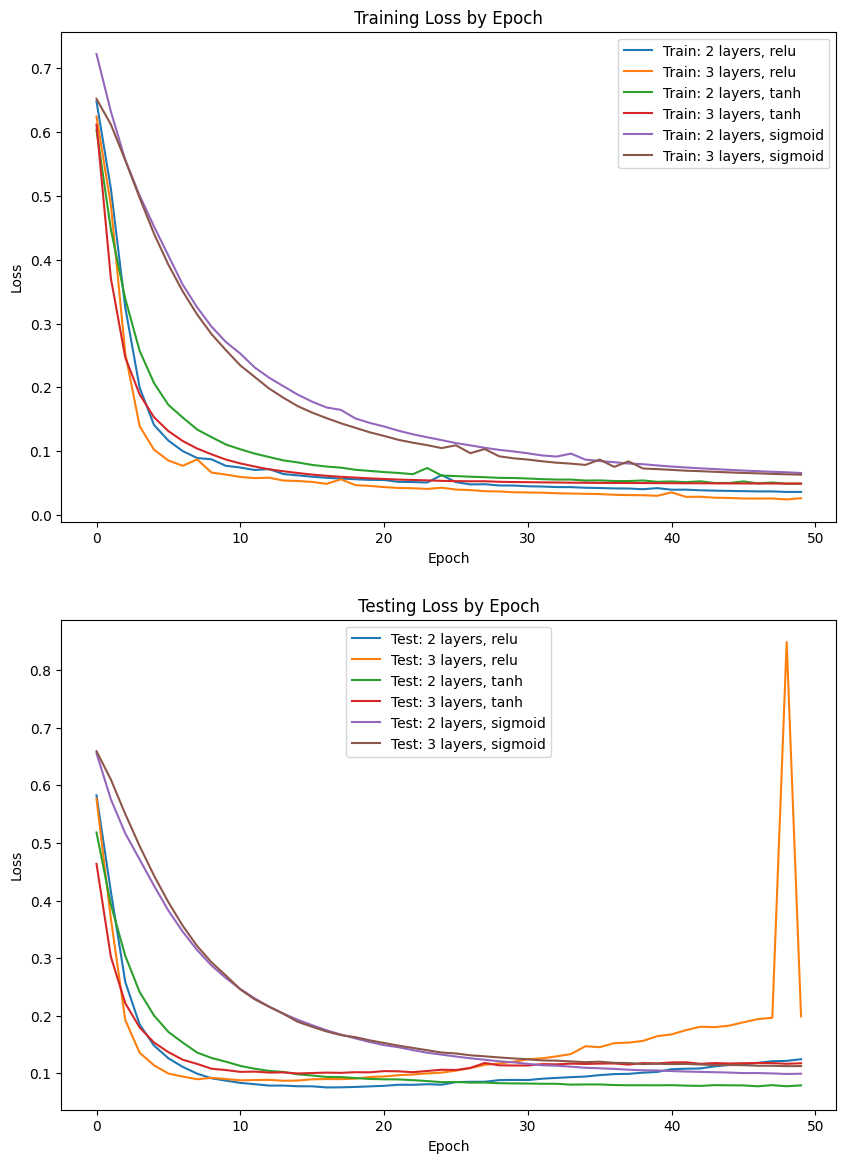

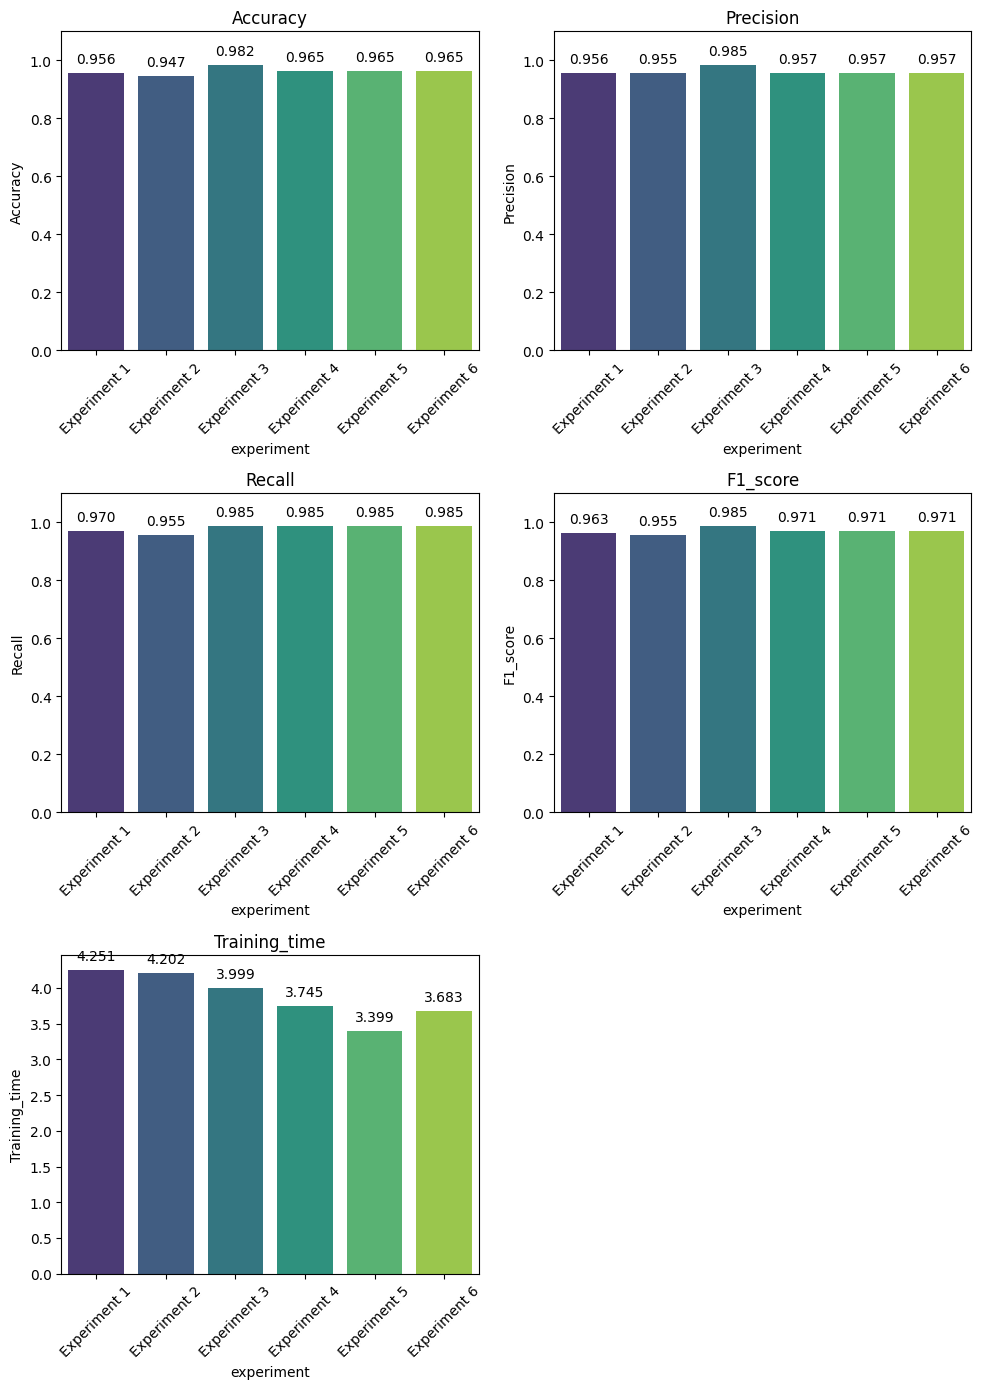

In [83]:
monitoring_results(exp_results)